# Class 9: LLM API Basics
## Objective: Introduction to LLM API usage


**Instructions:** Work with one or more students at your table. Discuss the key concepts and the code logic with one another. 

## This code block loads the main modules and checks the setup

Before you begin, you should have downloaded the `.env` and `.gitignore` files from carmen and put them in the same directory as your class notebooks.

In [3]:
# We will use this to suppress some warnings that are not important
import warnings

# Suppress specific Pydantic warnings that clutter the output
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

# We will use dotenv to read the .env file
from dotenv import load_dotenv
load_dotenv()

# This import will return an error if LiteLLM is not installed 
import litellm
import os

# Use this to measure response time
import time

# URL of Ohio State's LiteLLM proxy server
custom_api_base = "https://litellmproxy.osu-ai.org" 

# Our API key for Astronomy 1221 (keep this private to our class)
astro1221_key = os.getenv("ASTRO1221_API_KEY")
if astro1221_key:
    print("Successfully loaded Astronomy 1221 key")
else:
    print("Error: did not find key. Check that .env exists in the same folder/directory as your class notebooks")

# Check that .gitignore exists in this directory
if os.path.isfile('.gitignore'):
    print("Successfully found .gitignore in the current directory")
else:
    print("Error: Did not find .gitignore. Please download .gitignore from carmen and put in the same folder/directory as your class notebooks.")

with open('.gitignore', 'r') as f:
    content = f.read()
    if '.env' in content:
        print("Confirmed that .gitignore has the .env exclusion")
    else: 
        print("Error: Did not find .env in .gitignore. Please download .gitignore from carmen and put with your class notebooks.")


Successfully loaded Astronomy 1221 key
Successfully found .gitignore in the current directory
Confirmed that .gitignore has the .env exclusion


##### Section 1: Test LiteLLM

**Purpose:** Install and then test your LiteLLM setup

If you have not already installed LiteLLM, do the following in a JupyterLab **terminal** on your computer:

`pip install litellm`

In addition, make sure you have downloaded both the `.env` and `.gitignore` files from carmen and put both files in the same directory as your class notebooks.

In [4]:
# Define a function to query a model with LiteLLM

def prompt_llm(messages, model="openai/GPT-4.1-mini", temperature=0.2, max_tokens=1000):
    """
    Send a prompt or conversation to an LLM using LiteLLM and return the response.

    Parameters:
        messages: Either a string (single user prompt) or a list of message dicts with
                  "role" and "content". If a string, formatted as [{"role": "user", "content": messages}].
        model (str, optional): The name of the model to use. Defaults to "openai/GPT-4.1-mini".
        temperature (float, optional): Value between 0 and 2; higher values make output more random. Defaults to 0.2.
        max_tokens (int, optional): Maximum number of tokens to generate in the completion. Must be a positive integer. Defaults to 1000.

    Prints the answer returned by the model.
    
    Returns:
        response: The full response object from LiteLLM.

    Raises:
        ValueError: If `temperature` is not in [0, 2] or `max_tokens` is not a positive integer.
    """
    # If messages is a string, format it as a single user message
    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
    # Validate temperature
    if not (isinstance(temperature, (int, float)) and 0 <= temperature <= 2):
        raise ValueError("temperature must be a float between 0 and 2 (inclusive).")
    # Validate max_tokens
    if not (isinstance(max_tokens, int) and max_tokens > 0):
        raise ValueError("max_tokens must be a positive integer.")

    try: 
        print("Contacting LLM via University Server...")

        response = litellm.completion(
            model=model,
            messages=messages,
            api_base=custom_api_base,
            api_key=astro1221_key,
            temperature=temperature,
            max_tokens=max_tokens
        )

        answer = response['choices'][0]['message']['content']
        print(f"\nSUCCESS! Here is the answer from {model}:\n")
        print(answer)
        print("\n")

    except Exception as e:
        print(f"\nERROR: Could not connect. Details:\n{e}")    
        response = None

    return response

In [5]:
# Prompt to test the connection
prompt = "Explain the difference between a Type Ia and a core-collapse supernova in one sentence."

response = prompt_llm(prompt)

Contacting LLM via University Server...

SUCCESS! Here is the answer from openai/GPT-4.1-mini:

A Type Ia supernova occurs when a white dwarf in a binary system accretes enough mass to trigger a thermonuclear explosion, while a core-collapse supernova results from the gravitational collapse of a massive star’s iron core at the end of its life.




**Exercise:** Try a different prompt!

In [6]:
# Prompt to test the connection
prompt = "Provide an example prompt to test an LLM through an API interface suitable for an introductory astronomy data analysis course. Answer with just a few sentences."

response = prompt_llm(prompt)

Contacting LLM via University Server...

SUCCESS! Here is the answer from openai/GPT-4.1-mini:

Analyze the light curve data of a variable star provided in the attached CSV file. Identify the star’s period of variability using Fourier analysis, and explain what this period reveals about the star’s type and physical properties.




## Section 2: Content of the response

**Purpose:** The response includes lots of metadata, including the number of tokens you used, the model, and the cost of the query. 

The LiteLLM response is stored as a **PyDantic Model** called `ModelResponse`. We'll convert this to a dictionary and then look at the contents.

Run the cell below and examine the query metadata.

In [7]:
def show_response_metadata(response):
    '''
    Convert the response to a dictionary
    Print information about token usage and costs
    '''
    
    # Here are the top level keys
    response_dict = response.model_dump()
    print(f"Top-level keys: {response_dict.keys()}\n")
    
    # Here are more details: 
    # 1. Get the exact model version used by the server
    used_model = response.model
    
    # 2. Extract token counts from the 'usage' attribute
    input_tokens = response.usage.prompt_tokens
    output_tokens = response.usage.completion_tokens
    total_tokens = response.usage.total_tokens
    
    # 3. Calculate the cost (LiteLLM does the math based on current rates)
    cost = litellm.completion_cost(completion_response=response)
    
    print(f"--- Query Metadata ---")
    print(f"Model:        {used_model}")
    print(f"Input Tokens: {input_tokens}")
    print(f"Output Tokens:{output_tokens}")
    print(f"Total Tokens: {total_tokens}")
    print(f"Estimated Cost: ${cost:.6f}") # Showing 6 decimal places for small queries

show_response_metadata(response)

Top-level keys: dict_keys(['id', 'created', 'model', 'object', 'system_fingerprint', 'choices', 'usage', 'service_tier', 'prompt_filter_results'])

--- Query Metadata ---
Model:        gpt-4.1-mini-2025-04-14
Input Tokens: 36
Output Tokens:43
Total Tokens: 79
Estimated Cost: $0.000083


## Section 3: Model Comparison

**Purpose:** Compare the answers and costs of using three models

**Exercise:** Run the code block below and compare the following between the models:
- Qualify of Response
- Input Tokens
- Output Tokens
- Estimated Cost
- Elapsed Time

All are important considerations when choosing which model to use in your future code. 

**The bottom line is that you should choose the fastest and cheapest model that produces good enough results.**

In [9]:
# We will compare these models
models = ["gemini/gemini-2.5-flash", "openai/GPT-4.1-mini", "gemini/gemini-2.5-pro"]

# We will give each model the same prompt
prompt = "Explain the difference between a Type Ia and a core-collapse supernova in one sentence."

for model in models: 
    print('-' * 60)
    print(f"\nQuerying model {model}: ")
    start_time = time.time()
    response = prompt_llm(prompt, model=model)
    elapsed_time = time.time() - start_time
    show_response_metadata(response)
    print(f"Completed model {model} in {elapsed_time:.2f}s") 

------------------------------------------------------------

Querying model gemini/gemini-2.5-flash: 
Contacting LLM via University Server...

SUCCESS! Here is the answer from gemini/gemini-2.5-flash:

A Type Ia supernova is a thermonuclear explosion of a white dwarf star, while a core-collapse supernova is the gravitational collapse of a massive star's iron core.


Top-level keys: dict_keys(['id', 'created', 'model', 'object', 'system_fingerprint', 'choices', 'usage', 'vertex_ai_grounding_metadata', 'vertex_ai_url_context_metadata', 'vertex_ai_safety_results', 'vertex_ai_citation_metadata'])

--- Query Metadata ---
Model:        gemini-2.5-flash
Input Tokens: 17
Output Tokens:813
Total Tokens: 830
Estimated Cost: $0.002038
Completed model gemini/gemini-2.5-flash in 4.88s
------------------------------------------------------------

Querying model openai/GPT-4.1-mini: 
Contacting LLM via University Server...

SUCCESS! Here is the answer from openai/GPT-4.1-mini:

A Type Ia supernova o

## Section 4: Tuning the Model

The `prompt_llm()` function above has two other parameters: `temperature` and `max_tokens`. 

The `temperature` parameter is the creativity dial. The range is generally from 0.0 to 2.0, which corresponds to very deterministic to very creative. For scientific research, you should use a small value of temperature (0.0 to 0.3).

The `max_tokens` is a length limit that keeps the model from rambling and helps control costs. 

Run the cell below and compare the output from the same prompt with three different temperatures. Especially look at the response with temperature = 1.8 and in ModelResponse look for `finish_reason`. 

In [10]:
# Prompt to test the temperature parameter
prompt = "Describe the life of a high-mass star, from its birth in a nebula to its death in a supernova. Write this from the perspective of the star itself."

temperature_values = [0.0, 0.3, 1.8]
for temperature in temperature_values:
    print(f"Temperature = {temperature}")  
    response = prompt_llm(prompt, temperature=temperature)
    show_response_metadata(response)
    print('=' * 60)
    print("\n")

Temperature = 0.0
Contacting LLM via University Server...

SUCCESS! Here is the answer from openai/GPT-4.1-mini:

I was born in a vast, cold cloud of gas and dust—a nebula, where countless particles drifted silently in the darkness. Among them, I began to gather, pulled together by gravity’s relentless embrace. As more and more material spiraled inward, I grew hotter and denser at my core. The pressure became unbearable, and then, at last, I ignited. Nuclear fusion burst to life within me, turning hydrogen into helium and flooding me with radiant energy. I had become a star.

From that moment, I shone fiercely, burning brighter and hotter than many of my smaller siblings. My mass was immense—many times that of the Sun—and with such power came a brief but brilliant existence. I raced through my youth, fusing hydrogen rapidly in my core. The energy I produced pushed outward, balancing the crushing force of gravity trying to collapse me. This delicate dance kept me stable, a blazing beaco

**Test your understanding:** Experiment with the output with different temperature values and different prompts with the code below.

In [11]:
prompt = "What is right ascension?" # Experiment
temperature = 0.2 # Adjust to experiment
response = prompt_llm(prompt, temperature=temperature)
show_response_metadata(response)

Contacting LLM via University Server...

SUCCESS! Here is the answer from openai/GPT-4.1-mini:

Right ascension (RA) is a coordinate used in astronomy to specify the position of celestial objects on the celestial sphere. It is analogous to longitude on Earth but projected onto the sky.

Specifically:

- **Definition:** Right ascension is the angular distance measured eastward along the celestial equator from the vernal equinox (the point where the Sun crosses the celestial equator at the March equinox) to the hour circle passing through the object.

- **Units:** It is usually expressed in hours, minutes, and seconds, where 24 hours corresponds to a full 360° circle. Thus, 1 hour of RA equals 15 degrees.

- **Purpose:** RA, together with declination (which is analogous to latitude), forms the equatorial coordinate system, which astronomers use to pinpoint the location of stars, planets, and other celestial objects.

In summary, right ascension tells you how far east an object is along t

## Section 5: State and Memory

LLMs are technically stateless, which means they do not remember anything between prompts. To create the illusion of memory, they need to be told the entire conversation history with each new prompt. This can turn into a lot of token usage fairly quickly. 

Here is an example of how to manage this:

In [9]:
# 1. Initialize your "Memory" list with a System Message
chat_memory = [
    {"role": "system", "content": "You are a helpful astronomy research assistant appropriate for an introductory astronomy data analysis course."}
]

def chat_with_memory(user_input):
    # 2. Add the User's new message to memory
    chat_memory.append({"role": "user", "content": user_input})

    # 3. Send the WHOLE list to the LLM (uses notebook's custom_api_base and astro1221_key)
    response = prompt_llm(chat_memory)

    # 4. Extract the answer (handle None if connection failed)
    if response is None:
        return None
    ai_answer = response.choices[0].message.content

    # 5. CRITICAL: Add the AI's own answer to memory so it remembers what it said
    chat_memory.append({"role": "assistant", "content": ai_answer})

    return ai_answer


In [10]:
# Example usage:
prompt1 = "What is the distance to Andromeda?"
print(f"\nAsking about question 1: {prompt1}")
print(chat_with_memory(prompt1))
print('=' * 60)

prompt2 = "How much further is that than the Moon?"
print(f"\nAsking about question 2: {prompt2}")
print(chat_with_memory(prompt2)) # AI remembers Andromeda context
print('=' * 60)


Asking about question 1: What is the distance to Andromeda?
Contacting LLM via University Server...

SUCCESS! Here is the answer from openai/GPT-4.1-mini:

The distance to the Andromeda Galaxy (M31) is approximately 2.5 million light-years (about 780 kiloparsecs) from Earth.


The distance to the Andromeda Galaxy (M31) is approximately 2.5 million light-years (about 780 kiloparsecs) from Earth.

Asking about question 2: How much further is that than the Moon?
Contacting LLM via University Server...

SUCCESS! Here is the answer from openai/GPT-4.1-mini:

The average distance to the Moon is about 384,400 kilometers (or roughly 1.28 light-seconds).

The distance to Andromeda is about 2.5 million light-years.

To compare:

1 light-year ≈ 9.46 × 10^12 kilometers  
Distance to Andromeda ≈ 2.5 million × 9.46 × 10^12 km  
= 2.5 × 10^6 × 9.46 × 10^12 km  
= 2.365 × 10^19 kilometers

Distance to Moon ≈ 3.84 × 10^5 kilometers

Now, divide the distance to Andromeda by the distance to the Moon:

(

**Test your understanding:** Ask prompt2 again with `prompt_llm(prompt2)` and compare to the previous response. What is different? 

In [ ]:
# Ask question 2 without memory
prompt2 = "How much further is that than the Moon?"
response = prompt_llm(prompt2)

## Section 6: A chat agent

Adding all of the previous chats to the next one can quickly lead to ballooning token counts. As chats get longer, one strategy is to use the LLM to summarize the previous chats and use these summaries rather than all of the previous tokens. 

Here is an `AstronomyChatAgent` `class` that demonstrates how to do this.

In [ ]:
class AstronomyChatAgent:
    """Chat agent that uses this notebook's prompt_llm, custom_api_base, and astro1221_key."""

    def __init__(self, model="gemini/gemini-2.5-flash", system_prompt=None):
        self.model = model
        # Uses notebook globals: custom_api_base, astro1221_key (set in first code cell)
        if system_prompt is None:
            system_prompt = "You are a helpful Astronomy TA. Be concise and scientific."
        self.history = [{"role": "system", "content": system_prompt}]
        self.summary = "" # This will store the summary of the chat history

    def chat(self, user_input):
        self.history.append({"role": "user", "content": user_input})
        if len(self.history) > 10: # This is the number of chats before summarizing
            self._summarize_history() 

        # Use notebook's prompt_llm (same API base and key)
        response = prompt_llm(self.history, model=self.model)
        if response is None:
            self.history.pop()  # remove the user message we just added
            return None
        ai_answer = response.choices[0].message.content
        self.history.append({"role": "assistant", "content": ai_answer})
        return ai_answer

    def _summarize_history(self):
        """Compress old messages into a summary using prompt_llm."""
        print("\n--- Memory full. Summarizing previous context... ---")
        messages_to_summarize = self.history[1:-2]
        summary_prompt = f"Summarize the key astronomical facts discussed so far: {messages_to_summarize}"
        sum_res = prompt_llm(summary_prompt, model="openai/GPT-4.1-mini")
        if sum_res is None:
            self.summary = "(Summary failed.)"
        else:
            self.summary = sum_res.choices[0].message.content
        self.history = [
            self.history[0],
            {"role": "system", "content": f"Summary of previous chat: {self.summary}"},
            self.history[-2],
            self.history[-1],
        ]


In [ ]:
# Example usage (run the setup and prompt_llm cells first)
agent = AstronomyChatAgent()
print("AI:", agent.chat("What is the main sequence on the HR diagram?"))
print("AI:", agent.chat("Which star stays on it the longest?"))

## Section 7: Image Analysis

Astronomy often deals with image rather than text data, yet image data are typically encoded in binary format rather than strings. 

The solution is to convert the image into a **Base64** encoded string. This is a text representation of binary data. And then send this string in the query. 

First, we will download and display an image of the nearby galaxy M81 from this website: https://www.nasa.gov/image-article/spiral-galaxy-m81/

In [10]:
import requests
import matplotlib.pyplot as plt

# Download the public domain image
img_url = "https://www.nasa.gov/wp-content/uploads/2023/03/m81.jpg"
img_data = requests.get(img_url).content

with open("m81_tiny.jpg", "wb") as f:
    f.write(img_data)

print("Downloaded m81_tiny.png (Public Domain)")

Downloaded m81_tiny.png (Public Domain)


(np.float64(-0.5), np.float64(1040.5), np.float64(702.5), np.float64(-0.5))

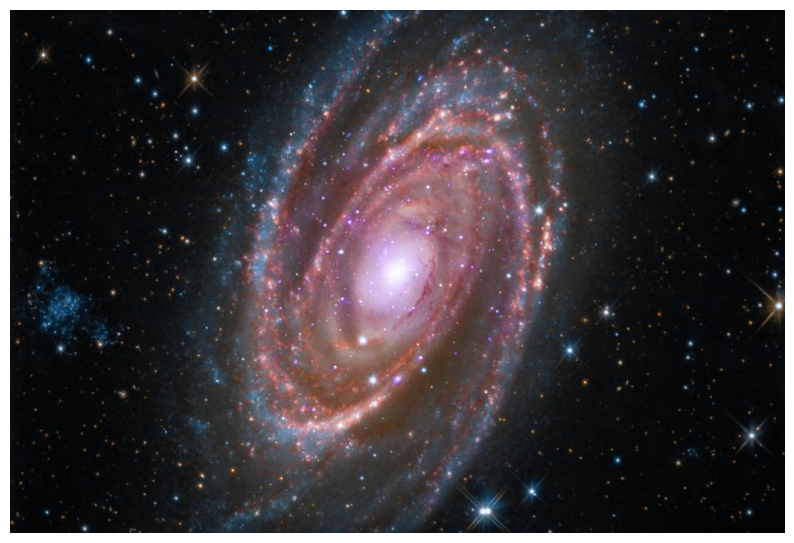

In [11]:
# Display the image with matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread("m81_tiny.jpg"))
ax.axis("off")  

In [12]:
import base64

def analyze_astronomical_image(image_path, question):
    """
    Encodes an image to Base64 and sends it to an LLM (Claude/Gemini) for analysis.
    """
    # 1. Read the image as binary and encode to Base64
    with open(image_path, "rb") as image_file:
        # Convert binary data to base64 string
        image_data = base64.b64encode(image_file.read()).decode('utf-8')

# 2. Format the message for a Vision-capable model (OpenAI/Gemini Standard)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": question},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_data}"
                    }
                }
            ]
        }
    ]
    # print(messages)

    # 3. Call a Vision-capable model (like Gemini Flash)
    response = litellm.completion(
        model="gemini/gemini-2.5-flash",
        messages=messages,
        api_base=custom_api_base,
        api_key=astro1221_key
    )

    show_response_metadata(response)
    return response.choices[0].message.content


In [13]:
# Example Usage:
result = analyze_astronomical_image("m81_tiny.jpg", "What morphological features do you see in this galaxy?")
print(result)

NameError: name 'show_response_metadata' is not defined

**Test your understanding:** Try a different question about this galaxy or try a different astronomical object. 

If you look for another object, I recommend searching for relatively small images to get faster responses and use fewer resources. 

In [ ]:
# Enter your code here